## Predicting Crashes in Financial Markets - Support Vector Machines
- Datasets: S&P500 (USA), Nikkei225 (Japan), SSE (Shanghai/China), HSI (Hong Kong), BSESN (India), SMI (Switzerland), BVSP (Brazil)
- Model: Support Vecor Machines (SVM)
- Number of features: 16 (mean price change and volatility for different windows over past 252 days)
- Response variable: Crash within 1, 3 or 6 months (0: no, 1:yes)
- Crash definition: Drawdown in 99.5% quantile

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from datetime import datetime, timedelta
from pylab import rcParams
import os
import importlib
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
os.chdir('/home/roman/Documents/Projects/Bubbles/models')
from prepare_data import DataLoader
from evaluate_results import EvaluateResults

In [2]:
# -------------------- Data preparation -------------------- #
os.chdir('../data')
datasets_original = ['^GSPC.csv', '^N225.csv', 'SSE.csv','^HSI.csv', '^BSESN.csv',\
                     '^SSMI.csv', '^BVSP.csv']
dataset_names = ['S&P 500', 'N225', 'SSE', 'HSI', 'BSESN', 'SMI', 'BVSP']

# specify drawdown thresholds for crashes (determined in exploration.ipynb):
# crashes according to Jacobsson:
crash_thresholds = [-0.0936, -0.1101, -0.1269, -0.1470, -0.1703, -0.1106, -0.2344]
# crashes according to Sornette:
# crash_thresholds = [-0.1053, -0.1495, -0.1706, -0.2334, -0.1563, -0.1492, -0.2264]
months = [1, 3, 6]   # <-- predict if crash n months ahead
data = DataLoader(datasets_original, dataset_names)
datasets_revised, crashes = data.get_data_revised(crash_thresholds)
dfs_x, dfs_y = data.get_dfs_xy(months=months)

In [3]:
# -------------------- Train SVM linear -------------------- #
model_name = 'SVM: linear Classification'
test_data = 'S&P 500'
month_prediction = 3
kernel = 'linear'
C = 1
class_weight = {0:.06, 1:.94}

index_test = [i for i, name in enumerate(dataset_names) if name == test_data][0]
index_month = [i for i, m in enumerate(months) if m == month_prediction][0]
training_set_names = list(dataset_names)
training_set_names.pop(index_test)
dfs_x_training = list(dfs_x)
dfs_x_training.pop(index_test)
dfs_y_training = list(dfs_y)
dfs_y_training.pop(index_test)
y_train_all, y_val_all = [], []
y_pred_train_all, y_pred_val_all = [], []
for val_data in training_set_names:
    x_train, y_train, x_val, y_val = data.get_train_test(dfs_x_training, dfs_y_training, \
            training_set_names, test_data=val_data)
    y_train, y_val = y_train[:, index_month].astype(int), y_val[:, index_month].astype(int)
    y_train_all.append(y_train)
    y_val_all.append(y_val)
    print('Train ' + str(model_name) + ' - validation data: ' + str(val_data))
    clf = svm.SVC(C=C, kernel=kernel, class_weight=class_weight)
    model = clf.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_train_all.append(y_pred_train)
    y_pred_val = model.predict(x_val)
    y_pred_val_all.append(y_pred_val)

Train SVM: linear Classification - validation data: N225
Train SVM: linear Classification - validation data: SSE
Train SVM: linear Classification - validation data: HSI
Train SVM: linear Classification - validation data: BSESN
Train SVM: linear Classification - validation data: SMI
Train SVM: linear Classification - validation data: BVSP


In [4]:
# -------------------- Evaluate results -------------------- #
eval_ = EvaluateResults(y_train_all, y_val_all, y_pred_train_all, y_pred_val_all, model_name,\
            test_data)
beta = 2
threshold = None
print(model_name)
print('\n')
print('Predict crash in:               ' + str(month_prediction) + ' months')
print('Threshold for positives:        ' + str(threshold))
print('Number of features:             ' + str(dfs_x[0].shape[1]))
print('Number of rows in training set: ' + str(len(y_pred_train_all[0]) + len(y_pred_val_all[0])))
print('\n')
eval_.training_results(threshold, training_set_names, beta=beta)

SVM: linear Classification


Predict crash in:               3 months
Threshold for positives:        None
Number of features:             16
Number of rows in training set: 42842


Results for each train/val split:
                       N225   SSE   HSI  BSESN   SMI  BVSP
positive actual train  0.04  0.04  0.04   0.04  0.04  0.04
positive pred train    0.14  0.14  0.15   0.14  0.13  0.13
precision train        0.17  0.13  0.13   0.14  0.13  0.14
recall train           0.55  0.41  0.44   0.43  0.40  0.40
accuracy_train         0.87  0.85  0.85   0.86  0.86  0.86
score_fbeta train      0.38  0.29  0.30   0.30  0.28  0.29
positive actual val    0.05  0.04  0.04   0.04  0.05  0.04
positive pred val      0.18  0.13  0.15   0.13  0.12  0.08
precision val          0.06  0.19  0.11   0.11  0.17  0.23
recall val             0.24  0.72  0.42   0.35  0.37  0.46
accuracy val           0.79  0.88  0.85   0.86  0.87  0.91
score fbeta val        0.15  0.46  0.27   0.24  0.30  0.38


Results - avera

In [5]:
# -------------------- Test model -------------------- #
x_train, y_train, x_test, y_test = data.get_train_test(dfs_x, dfs_y, dataset_names,\
            test_data=test_data)
y_train, y_test = y_train[:, index_month].astype(int), y_test[:, index_month].astype(int)
clf = svm.SVC(C=C, kernel=kernel, class_weight=class_weight)
model = clf.fit(x_train, y_train)
y_pred_test_bin = model.predict(x_test).astype(int)
threshold = None
_ = eval_.test_results(y_test, y_pred_test_bin, threshold, beta=beta)

Test results (test set: S&P 500):
Positive test cases actual:         0.04
Positive test cases predicted:      0.13
Precision test (model/random):      0.16 / 0.04
Recall test (model/random):         0.52 / 0.13
Accuracy test (model/random):       0.87 / 0.84
Score test fbeta:                   0.36 / 0.09


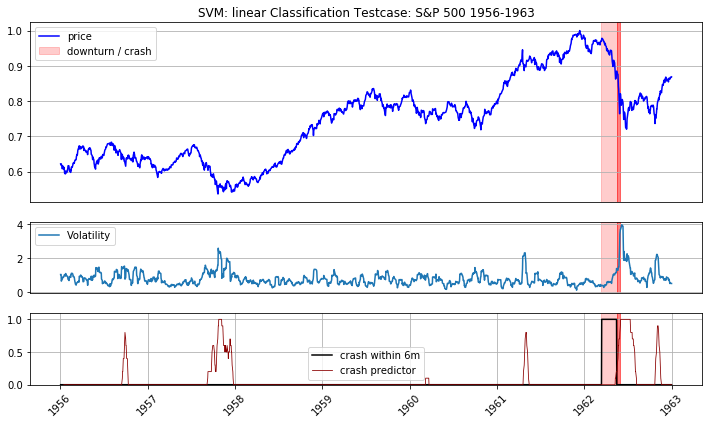

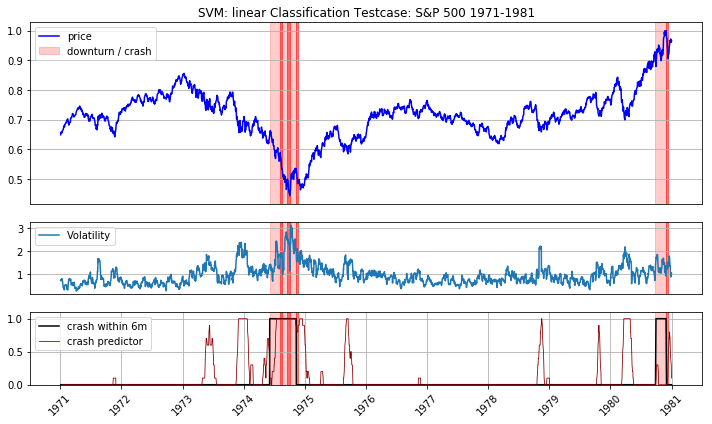

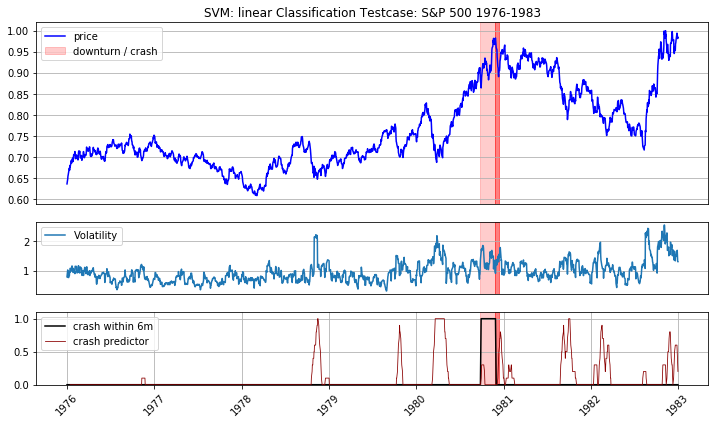

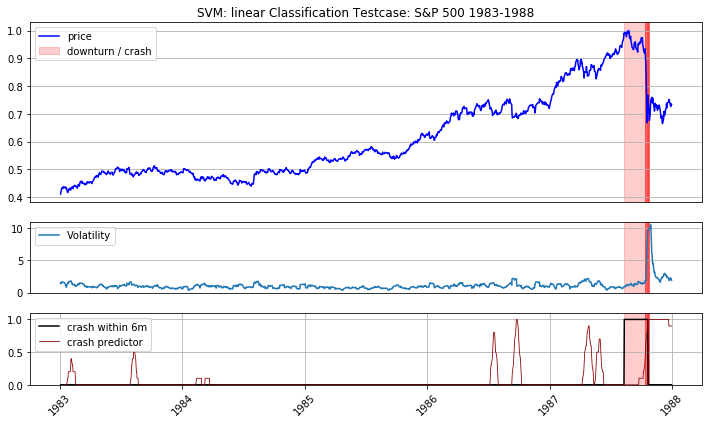

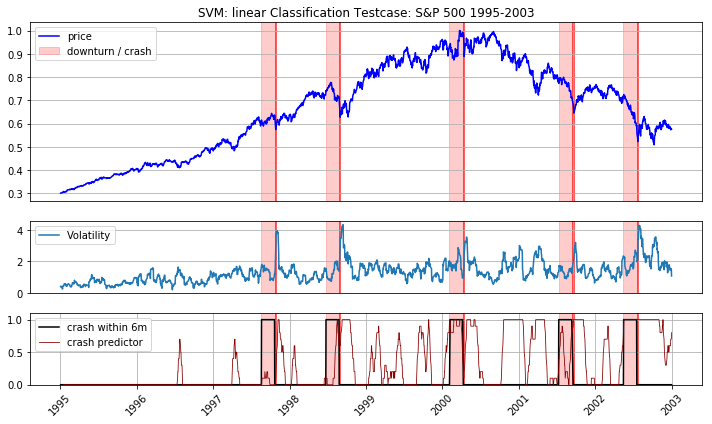

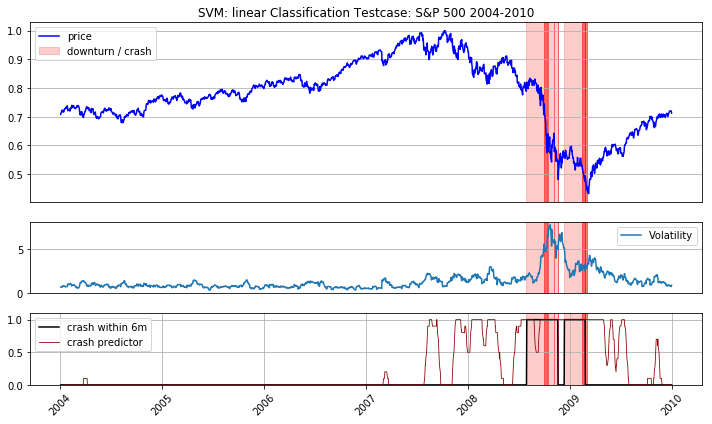

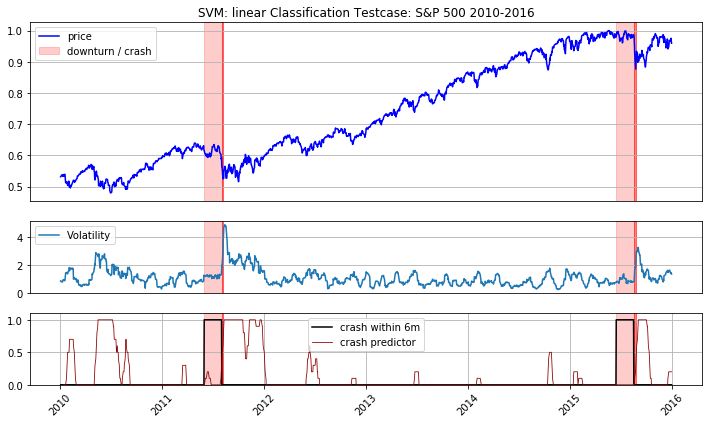

In [6]:
# -------------------- Plot test results -------------------- #
df = datasets_revised[index_test].reindex(dfs_x[index_test].index)
df['y'] = y_test
df['y_pred'] = y_pred_test_bin
c = crashes[index_test]
t_start = ['1956-01-01', '1971-01-01', '1976-01-01', '1983-01-01', '1995-01-01', '2004-01-01',\
           '2010-01-01']
t_end = ['1963-01-01', '1981-01-01', '1983-01-01', '1988-01-01', '2003-01-01', '2010-01-01',\
           '2016-01-01']
#plt.rcParams.update(plt.rcParamsDefault)
rcParams['figure.figsize'] = 10, 6
eval_.plot_test_results(df, c, t_start, t_end)

In [7]:
# -------------------- Current prediction S&P 500 -------------------- #
# train on all available data:
x_train_final, y_train_final, _, _ = data.get_train_test(dfs_x, dfs_y, dataset_names,\
        test_data=None)
C = [1, 1, 1]
class_weights = [{0:.06, 1:.94}, {0:.06, 1:.94}, {0:.08, 1:.92}]
dataset_original = ['^GSPC_11-05.csv']
dataset_name = ['S&P 500']
crash_threshold = [-0.0936]
data_new = DataLoader(dataset_original, dataset_name)
dataset_revised, crashes = data_new.get_data_revised(crash_threshold)
dfs_x_new, dfs_y_new = data_new.get_dfs_xy_predict(months=months)
x_new, _, _, _ = data_new.get_train_test(dfs_x_new, dfs_y_new, dataset_name, test_data=None)

for index_month in range(len(months)):
    y_train_final_ = y_train_final[:, index_month].astype(int)
    clf = svm.SVC(C=C[index_month], kernel=kernel, class_weight=class_weights[index_month])
    model = clf.fit(x_train_final, y_train_final_)
    y_pred_new_bin = model.predict(x_new).astype(int)
    current_pred = np.dot(np.linspace(0,1,21) / sum(np.linspace(0,1,21)), y_pred_new_bin[-21:])
    print(str(model_name) + ' prediction of a crash within ' + str(months[index_month]) \
          + ' months: ' + str(np.round(current_pred, 2)))

SVM: linear Classification prediction of a crash within 1 months: 0.24
SVM: linear Classification prediction of a crash within 3 months: 0.79
SVM: linear Classification prediction of a crash within 6 months: 0.83
